In [5]:
using CSV
using DataFrames
using ScikitLearn
using Statistics
using Plots
using ScikitLearn.CrossValidation: train_test_split

# Import RandomForestClassifier and accuracy_score using @sk_import
@sk_import ensemble: RandomForestClassifier
@sk_import metrics: accuracy_score
@sk_import metrics: confusion_matrix



PyObject <function confusion_matrix at 0x29dfea830>

In [7]:

# Load data
data = CSV.File("71-80.csv") |> DataFrame


function normalize(df::AbstractDataFrame, cols::Vector{<:AbstractString})
    means = mean.(eachcol(df[:, cols]))
    stds = std.(eachcol(df[:, cols]))

    # Convert means and stds to the appropriate shape for broadcasting
    means_matrix = repeat(means', nrow(df), 1)
    stds_matrix = repeat(stds', nrow(df), 1)

    return (df[:, cols] .- means_matrix) ./ stds_matrix
end


# Calculate the new features based on the citation column names provided
for year in 2017:2021
    new_feature_name = "growth_rate_" * string(year+1)
    citation_current_year = Symbol("cit_" * string(year))
    citation_next_year = Symbol("cit_" * string(year+1))
    
    # We'll use an element-wise operation to avoid division by zero
    data[!, new_feature_name] = ifelse.(data[:, citation_current_year] .== 0, 0, 
                                        (data[:, citation_next_year] .- data[:, citation_current_year]) ./ data[:, citation_current_year])
end



In [8]:


# Normalize the new features
growth_rate_features = ["growth_rate_2018", "growth_rate_2019", "growth_rate_2020", "growth_rate_2021", "growth_rate_2022"]
X_normalized = normalize(data, growth_rate_features)

# Normalize citation data and classify the ratio
data[:, "ratio"] = data[:, "cit_2022"] ./ data[:, "cit_2021"]
data[:, "category"] = ifelse.(data[:, "ratio"] .< 1.05, 1, ifelse.(data[:, "ratio"] .< 1.15, 2, 3))


# Convert the normalized data to a Matrix for the features
X_matrix = Matrix(X_normalized)
y_vector = Vector(data[:, "category"])  # Convert the target variable to a Vector

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_vector, test_size=0.2, random_state=42)


4-element Vector{Array}:
 [-0.3062954589538106 -0.09184008720611209 … -0.6750153675210967 0.2975977018475001; -0.8230862735707785 0.2815844276819949 … 0.7734888235871826 -1.178765745396786; … ; -0.4307520400632083 -0.4075387050750635 … -0.5383224301562363 -1.1159378942435507; -0.3589209817392553 -0.30864139103974036 … -0.4585397574139464 -0.33687253994343275]
 [-0.12737432345840305 -0.6830383656020352 … 0.08500226361596343 -0.7284507750380156; 0.8609708756836009 0.24396908386454888 … 0.6385298104110061 0.45478110713747805; … ; -0.19210031562728433 0.012206419349565662 … -0.2623915039839135 -0.5649984407759543; -0.2884323753343124 -0.40019914423739344 … -0.39278237312915465 -0.20524102899307134]
 [3, 1, 3, 1, 3, 3, 1, 1, 1, 3  …  3, 1, 1, 1, 1, 1, 1, 2, 1, 1]
 [1, 3, 3, 1, 1, 3, 3, 2, 3, 1, 1, 3, 1, 1, 3, 3, 2, 1, 1, 1]

In [9]:

# Create the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
fit!(model, X_train, y_train)


PyObject RandomForestClassifier(random_state=42)

In [10]:

# Predict the categories of the test set
y_pred = predict(model, X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
println("Accuracy: $accuracy")


Accuracy: 1.0


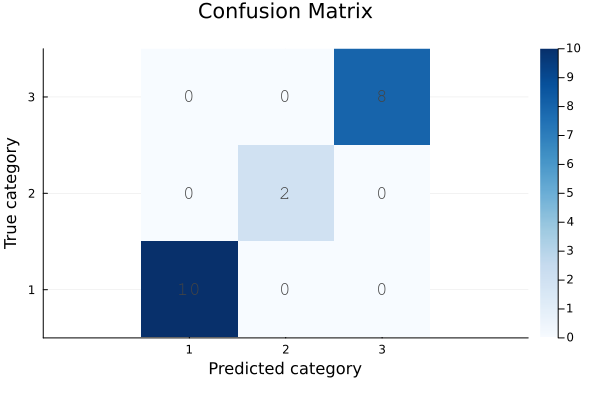

In [11]:

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
categories = sort(unique(y_vector))
plt = heatmap(cm, color=:Blues, xlabel="Predicted category", ylabel="True category", title="Confusion Matrix",
              xticks=(1:length(categories), categories), yticks=(1:length(categories), categories), aspect_ratio=:equal)

for (i, actual_category) in enumerate(categories)
    for (j, predicted_category) in enumerate(categories)
        annotate!(plt, j, i, text(string(cm[i, j]), :center, :middle, 10))
    end
end

display(plt)
